# Exact GP Regression on Classification Labels: A 2D Example

For dataset size < 10,000, ExactGP works fine.

"In GPyTorch, Exact GP inference is still our preferred approach to large regression datasets. By coupling GPU acceleration with BlackBox Matrix-Matrix Inference and LancZos Variance Estimates (LOVE), GPyTorch can perform inference on datasets with over 1,000,000 data points while making very few approximations."
--[GPyTorch docs](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/index.html)

Sources:
https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html

Paper:
https://proceedings.neurips.cc/paper_files/paper/2018/file/b6617980ce90f637e68c3ebe8b9be745-Paper.pdf




In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.seed=0

/tmp/ipykernel_2305/140972768.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Generate data for training and test sets 
 
$f(x1,x2) = \sin(0.15\pi u + (x1+x2))+1, \text{where } u \sim \text{Unif}(0,1).$

$ y = \text{round}((f(x1,x2)).$


In [2]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)
    
    # 2D data
    x1 = torch.randn(num_data,1)
    x2 = torch.randn(num_data,1)

    u = torch.rand(1)
    
    # Define response as a function of x1 and x2
    data_fn = lambda x1, x2: 1 * torch.sin(0.15 * u * 3.1415 * (x1 + x2)) + 1
    latent_fn = data_fn(x1, x2)
    
    # Response
    z = torch.round(latent_fn).long().squeeze()
    
    return torch.cat((x1,x2),dim=1), z, data_fn


(500,)


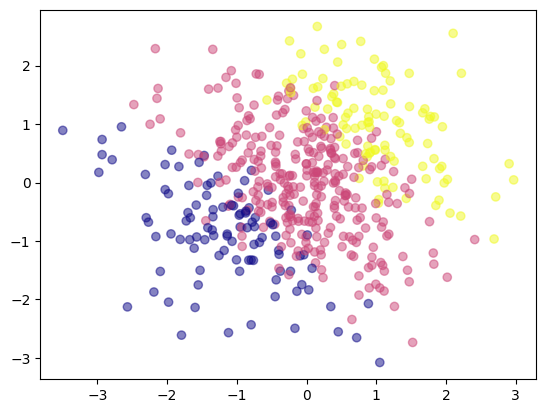

In [3]:
train_x, train_y, genfn = gen_data(500)

print(train_x[:,0].numpy().shape)

# Genearte noise with same size as that of the data.
noise1 = np.random.normal(0,0.3, train_x[:,0].numpy().shape) #  μ = 0, σ = 2, size = length of x or y. Choose μ and σ wisely.
noise2 = np.random.normal(0,0.3, train_x[:,1].numpy().shape) #  μ = 0, σ = 2, size = length of x or y. Choose μ and σ wisely.

train_x_noise1 = train_x[:,0].numpy()+noise1
train_x_noise2 = train_x[:,1].numpy()+noise2

train_x_noise1 = train_x_noise1.astype(np.float32)
train_x_noise2 = train_x_noise2.astype(np.float32)

plt.scatter(train_x_noise1, train_x_noise2, c = train_y,alpha=0.5, cmap='plasma')

x1 = torch.from_numpy(train_x_noise1).view(len(noise1),-1)
x2 = torch.from_numpy(train_x_noise2).view(len(noise2),-1)

train_x = torch.cat((x1,x2),dim=1)

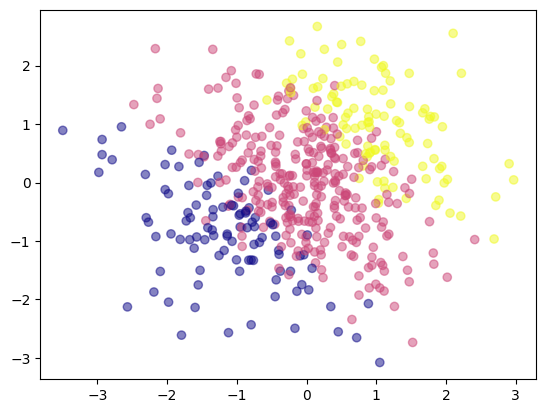

In [4]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y,alpha=0.5, cmap='plasma')

In [5]:
y=train_y.numpy()
print(np.unique(y))

[0 1 2]


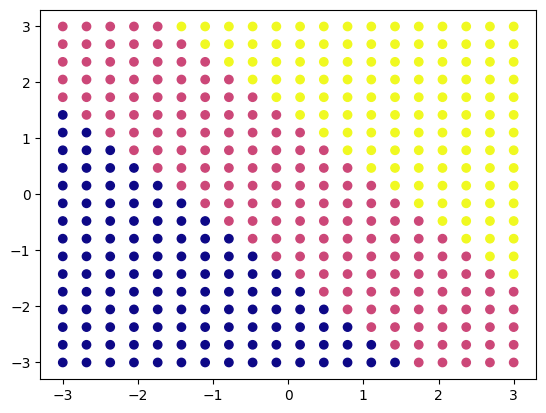

In [6]:
# Decision boundary and test sets
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_d1_mat, test_d2_mat = np.meshgrid(test_d1, test_d2)

# Convert to torch tensor
test_d1_mat, test_d2_mat = torch.Tensor(test_d1_mat), torch.Tensor(test_d2_mat)
test_x = torch.cat((test_d1_mat.view(-1,1), test_d2_mat.view(-1,1)),dim=1)


# Obtain response label
test_labels = torch.round(genfn(test_d1_mat,test_d2_mat))
test_y = test_labels.view(-1)
#print(test_labels)
#print(test_y)

plt.scatter(test_d1_mat, test_d2_mat, c = test_y, cmap='plasma')

In [7]:
# Test data
# Save to file
#test_df = pd.DataFrame(test_x, columns=["x1","x2"])
#test_df["response"] = test_y
#test_df

In [8]:
#test_df.to_csv("/p/lustre2/fan4/myGPyTorch/data/classification3_test.csv", index=0)

In [9]:
#test_df = pd.read_csv("/p/lustre2/fan4/myGPyTorch/data/classification3_test.csv",dtype="float32")
#test_x_temp = test_df.drop(columns=["response"]).to_numpy()
#test_y_temp = test_df["response"].to_numpy().astype("long")

# Torch tensor requires "long" type
#test_x = torch.from_numpy(test_x_temp)
#test_y = torch.from_numpy(test_y_temp)


#test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
#test_labels = torch.round(genfn(test_x_mat, test_y_mat))
#test_y = test_labels.view(-1)

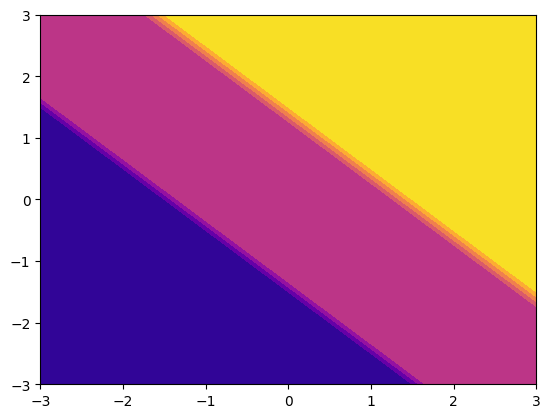

In [10]:
plt.contourf(test_d1_mat.numpy(), test_d2_mat.numpy(), test_labels.numpy(), cmap='plasma')

## Setting up the Model

The Dirichlet GP model is an exact GP model with a couple of caveats. 
1. First, it uses a special likelihood: a DirichletClassificationLikelihood, and 
2. second, it is natively a multi-output model (for each data point, we need to predict `num_classes`, $C$, outputs) so we need to specify the batch shape for our mean and covariance functions.

The DirichletClassificationLikelhood is just a special type of `FixedGaussianNoiseLikelihood` that does the required data transformations into a regression problem for us. Succinctly, we soft one hot encode the labels into $C$ outputs so that $\alpha_i=\alpha_{\epsilon}$ if $y_c=0$ and $\alpha_i=1+\alpha_{\epsilon}$ if $y_c=1$ Then, our variances are $\sigma^2=\log(1./\alpha+1.)$ and our targets are $\log(\alpha)-0.5\sigma^2$. 

That is, rather than a classification problem, we have a regression problem with outputs. For more details, please see the original paper.



In [11]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


In [12]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 7.103   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 6.603   lengthscale: 0.961   noise: 0.670
Iter 11/50 - Loss: 6.440   lengthscale: 1.204   noise: 0.785
Iter 16/50 - Loss: 6.378   lengthscale: 1.371   noise: 0.903
Iter 21/50 - Loss: 6.347   lengthscale: 1.450   noise: 0.947
Iter 26/50 - Loss: 6.324   lengthscale: 1.457   noise: 0.935
Iter 31/50 - Loss: 6.304   lengthscale: 1.414   noise: 0.905
Iter 36/50 - Loss: 6.286   lengthscale: 1.347   noise: 0.854
Iter 41/50 - Loss: 6.270   lengthscale: 1.267   noise: 0.819
Iter 46/50 - Loss: 6.257   lengthscale: 1.187   noise: 0.796


## Model Predictions

In [13]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    
    # Obtain variance
    observed_pred = likelihood(model(test_x))

# The model gives multi-output predictions
print("Predicting the logits for each class in the classification problem.")
print(pred_means.numpy().shape)
print(pred_means)

#------------------------------------------
# Convert predictions to response labels
#------------------------------------------
# Compute the elementwise maximum at each test point
# Taking maxinum values at the first axis (.max(0)).
# Take the maximun indices as the response labels [1].
print(pred_means.max(0)[1])

Predicting the logits for each class in the classification problem.
(3, 400)
tensor([[-1.4095, -1.3053, -1.2298,  ..., -4.5973, -4.2320, -3.8652],
        [-3.9407, -4.3168, -4.7434,  ..., -4.5094, -4.0775, -3.7197],
        [-3.9505, -4.3129, -4.6593,  ..., -1.2140, -1.2841, -1.4731]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2

In [14]:
#------------------------------------------
# Convert predictions to response labels
#------------------------------------------
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(400,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,

We’ve predicted the logits for each class in the classification problem, and can clearly see that 
1. the logits for class 0 are highest in the bottom left, 
2. the logits for class 2 are highest in the top right, and 
3. the logits for class 1 are highest in the middle.

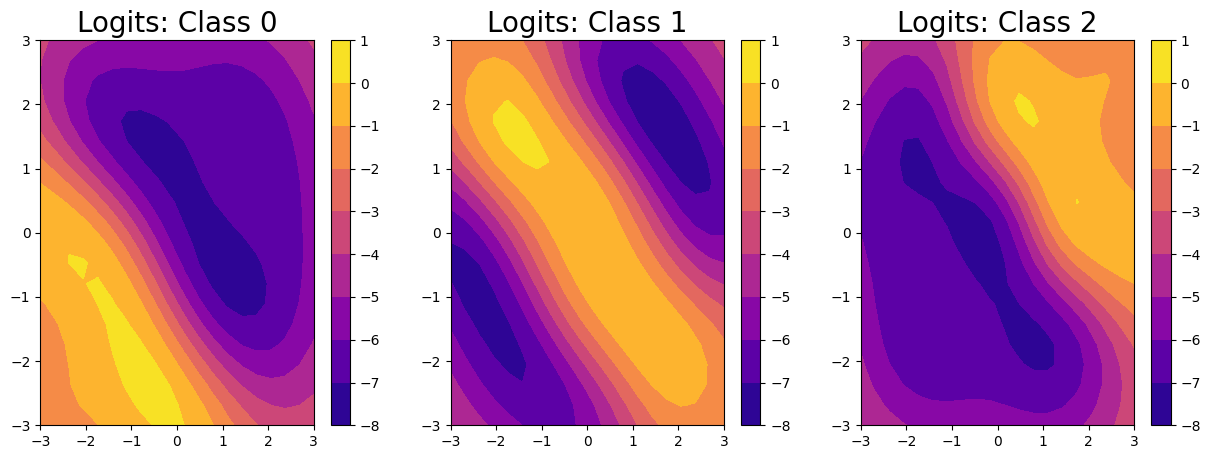

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_d1_mat.numpy(), test_d2_mat.numpy(), pred_means[i].numpy().reshape((20,20)), cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)



Unfortunately, we can’t get closed form estimates of the probabilities; however, we can approximate them with a lightweight sampling step using $J$ samples from the posterior as:


$\displaystyle\mathbb{E}(p(y_i=j)) = \int \frac{\exp\{f_i^*\}}{\sum_k^C\exp\{f_i^*\}}p(f^*\|y)df^* \approx \frac{1}{J}\sum_j^J\frac{\exp\{f_{i,j}^*\}}{\sum_k^C\exp\{f_{i,j}^*\}}$. 

Here, we draw __256__ samples from the posterior.



In [16]:
# Draw samples from the posterior.
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

/global/scratch/users/fan4/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/global/scratch/users/fan4/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/global/scratch/users/fan4/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


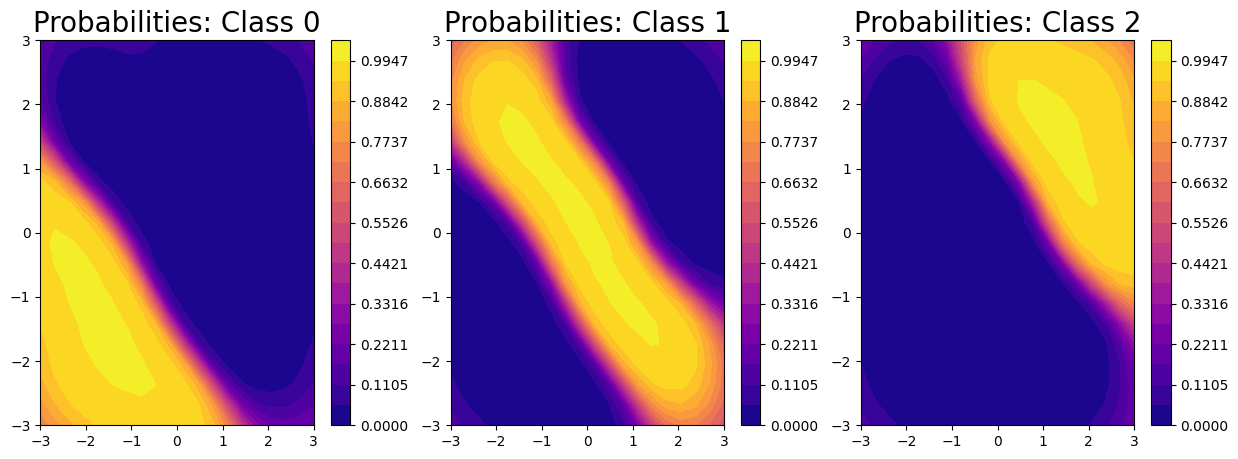

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_d1_mat.numpy(), test_d2_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels, cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Finally, we plot the decision boundary (on the right) and the true decision boundary on the left. They align pretty closely.

To get the decision boundary from our model, all we need to do is to compute the elementwise maximium at each test point.

Text(0.5, 1.0, 'Estimated Response')

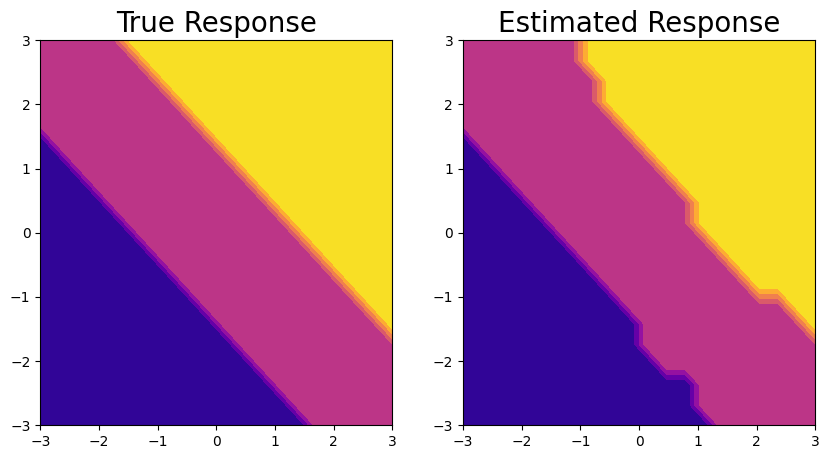

In [18]:
# Decision boundary
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_d1_mat.numpy(), test_d2_mat.numpy(), test_labels.numpy(), cmap='plasma')
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_d1_mat.numpy(), test_d2_mat.numpy(), pred_means.max(0)[1].reshape((20,20)), cmap='plasma')
ax[1].set_title('Estimated Response', fontsize=20)

## Variances (Uncertainties)

In [19]:
lower, upper = observed_pred.confidence_region()
upper

tensor([[ 1.7876,  1.7082,  1.6199,  ..., -1.3283, -0.8447, -0.3548],
        [-0.4728, -1.0152, -1.6028,  ..., -1.2428, -0.6692, -0.1600],
        [-0.6666, -1.1743, -1.6669,  ...,  1.4519,  1.5836,  1.6402]])

In [20]:
print(observed_pred.variance.numpy().shape)
pred_variance = observed_pred.variance.numpy()
pred_variance

(3, 400)


array([[2.5554063, 2.2703068, 2.0301266, ..., 2.6716049, 2.868343 ,
        3.0807135],
       [3.0066843, 2.7252648, 2.4657238, ..., 2.6675677, 2.904054 ,
        3.1678212],
       [2.695863 , 2.4626024, 2.2386215, ..., 1.7766981, 2.055973 ,
        2.423064 ]], dtype=float32)

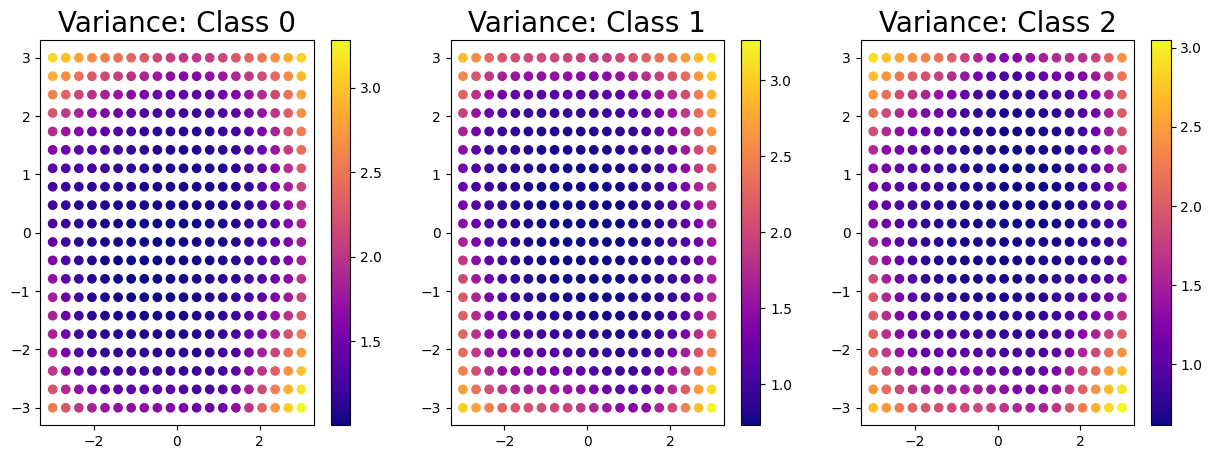

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].scatter(
        test_d1_mat.numpy(), test_d2_mat.numpy(), c=pred_variance[i].reshape((20,20)), cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Variance: Class " + str(i), fontsize = 20)



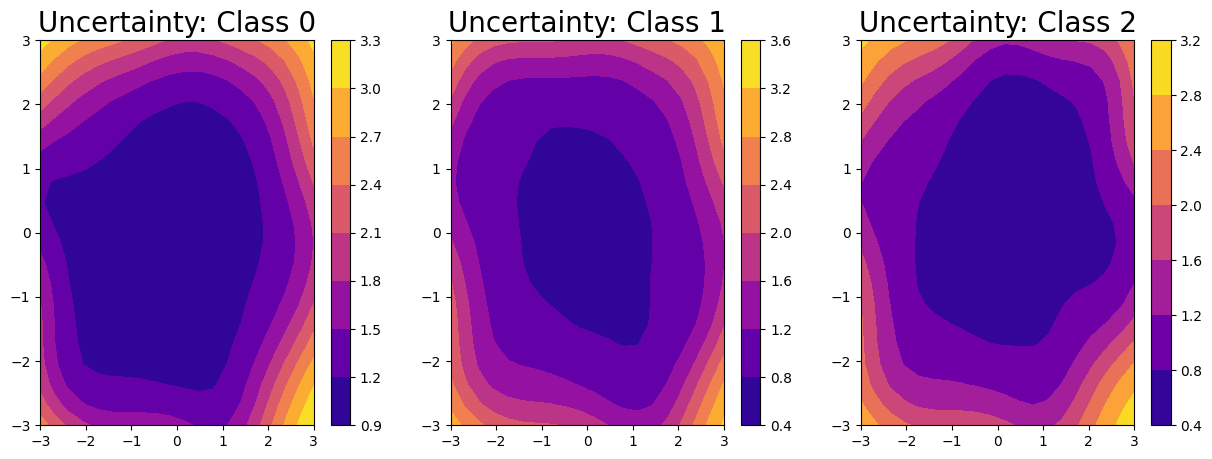

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].contourf(
        test_d1_mat.numpy(), test_d2_mat.numpy(), pred_variance[i].reshape((20,20)), cmap='plasma',
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Uncertainty: Class " + str(i), fontsize = 20)


In [23]:
x1 = test_d1_mat.numpy().reshape(-1)
x2 = test_d2_mat.numpy().reshape(-1)
v1 = pred_variance[0].reshape(-1)
v2 = pred_variance[1].reshape(-1)
v3 = pred_variance[2].reshape(-1)

data = np.array([x1,x2,v1,v2,v3]).transpose()
df = pd.DataFrame(data, columns=['x1','x2','v1','v2','v3'])
df                                             

,x1,x2,v1,v2,v3
0,-3.000000,-3.0,2.555406,3.006684,2.695863
1,-2.684211,-3.0,2.270307,2.725265,2.462602
2,-2.368421,-3.0,2.030127,2.465724,2.238621
3,-2.052632,-3.0,1.853146,2.262793,2.057404
4,-1.736842,-3.0,1.742173,2.132072,1.938368
...,...,...,...,...,...
395,1.736842,3.0,2.382328,2.360683,1.611676
396,2.052632,3.0,2.510736,2.490161,1.643149
397,2.368421,3.0,2.671605,2.667568,1.776698
398,2.684211,3.0,2.868343,2.904054,2.055973


## Zoomed in view

In [24]:
x1lower = -1.2
x1upper = 1.2
x2lower = -1.2
x2upper = 1.2

df_select = df.loc[(df['x1']>x1lower) & (df['x1']<x1upper) & (df['x2']>x2lower) & (df['x2']<x2upper)]
df_select


,x1,x2,v1,v2,v3
126,-1.105263,-1.105263,1.018433,0.824346,0.728443
127,-0.789474,-1.105263,1.012324,0.792278,0.703142
128,-0.473684,-1.105263,1.011378,0.766931,0.683763
129,-0.157895,-1.105263,1.017934,0.752146,0.675500
130,0.157895,-1.105263,1.032643,0.748915,0.681271
...,...,...,...,...,...
269,-0.157895,1.105263,1.053668,0.751323,0.645739
270,0.157895,1.105263,1.046263,0.752289,0.627949
271,0.473684,1.105263,1.047695,0.763578,0.618164
272,0.789474,1.105263,1.059828,0.786427,0.617123


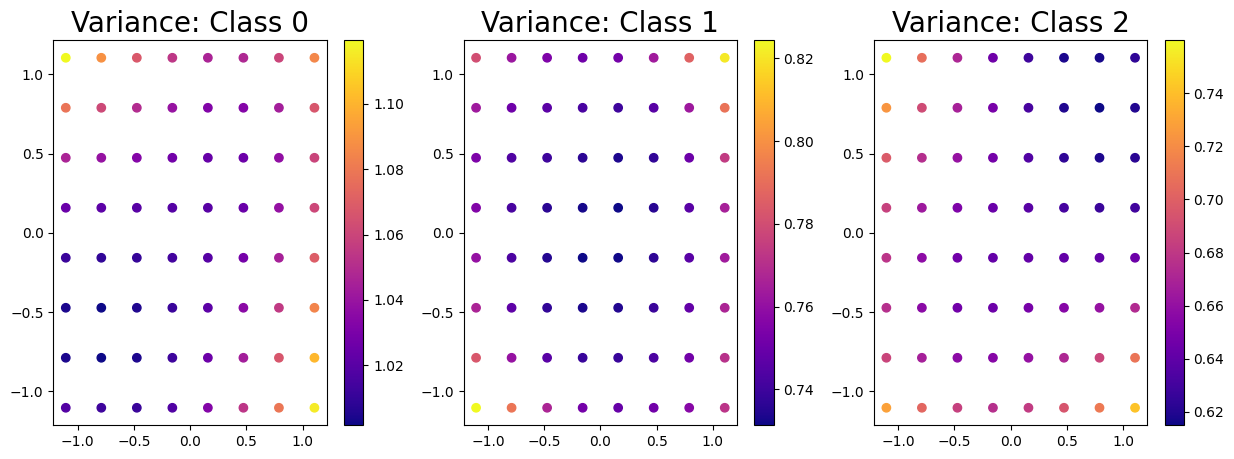

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
y = df_select[['v1','v2','v3']].copy().to_numpy()

for i in range(3):
    im = ax[i].scatter(
        df_select['x1'].to_numpy(), df_select['x2'].to_numpy(), c=y[:,i], cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Variance: Class " + str(i), fontsize = 20)



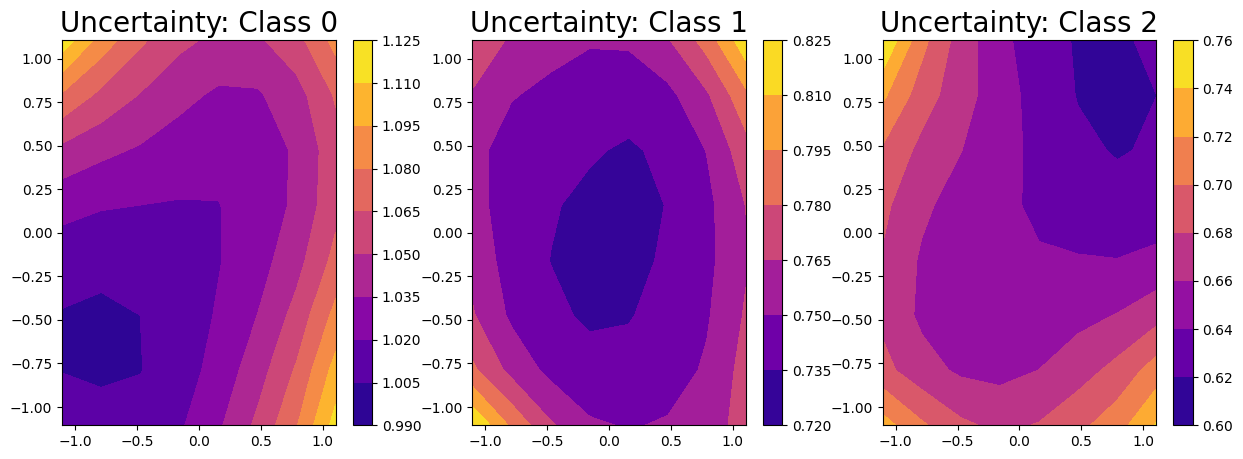

In [26]:
select_d1_mat = df_select['x1'].to_numpy().reshape((8,8))
select_d2_mat = df_select['x2'].to_numpy().reshape((8,8))


fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].contourf(
        select_d1_mat, select_d2_mat, y.T[i].reshape((8,8)), cmap='plasma',
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Uncertainty: Class " + str(i), fontsize = 20)


## Training set prediction

In [27]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    train_dist = model(train_x)
    train_pred_means = train_dist.loc
    
    # Obtain variance
    train_observed_pred = likelihood(model(train_x))

# The model gives multi-output predictions
print("Predicting the logits for each class in the classification problem.")
print(train_pred_means.numpy().shape)

#------------------------------------------
# Convert predictions to response labels
#------------------------------------------
train_prediction = model(train_x).loc.max(0)[1].numpy()
print(train_prediction.shape)
train_prediction

Predicting the logits for each class in the classification problem.
(3, 500)
(500,)


/global/scratch/users/fan4/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


array([1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 2, 2, 2,
       1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 0, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0,
       1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 2, 1,
       0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2,
       1, 1, 0, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2,

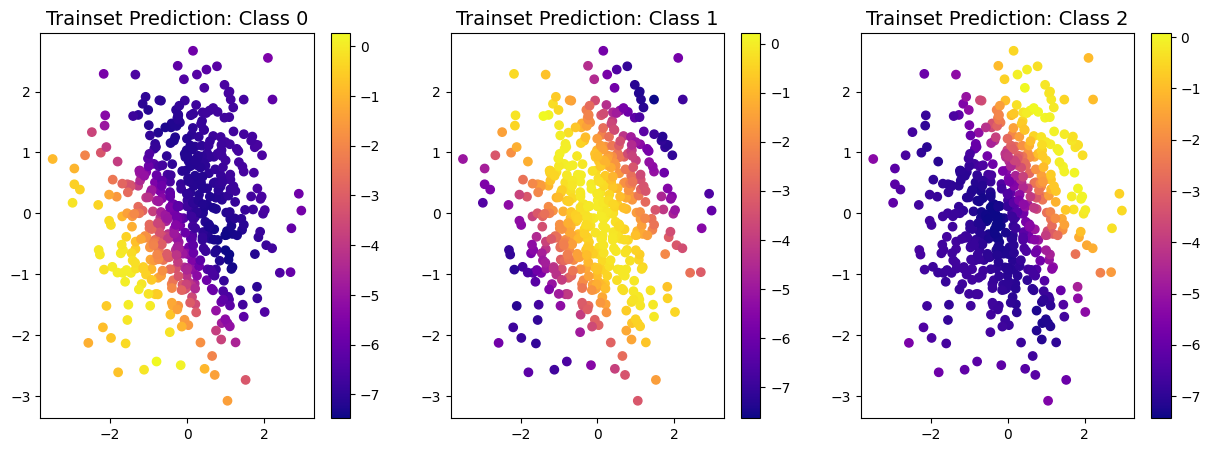

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].scatter(
        train_x[:,0].numpy(), train_x[:,1].numpy(), c=train_pred_means[i].numpy(), cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Trainset Prediction: Class " + str(i), fontsize = 14)



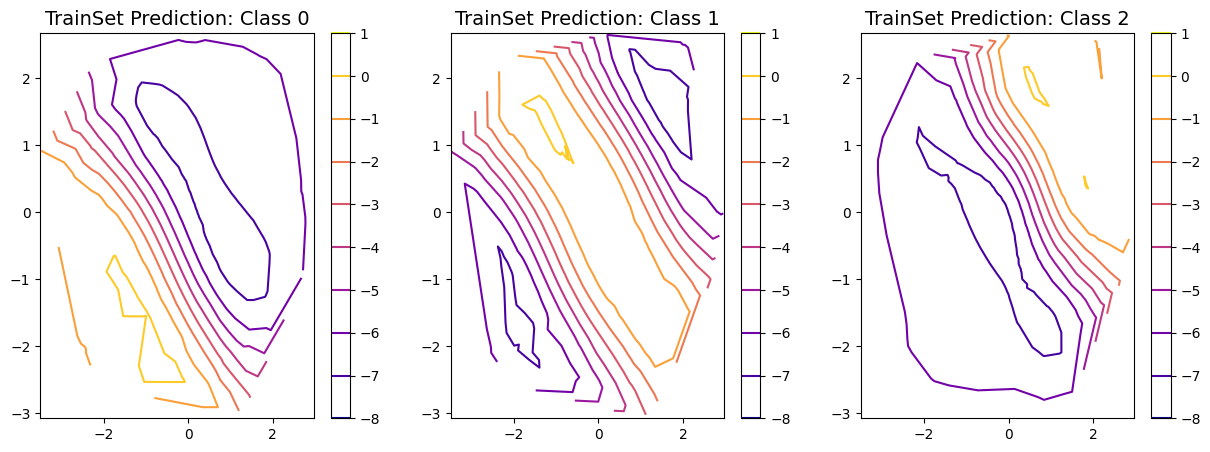

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].tricontour(
        train_x[:,0].numpy(), train_x[:,1].numpy(), train_pred_means[i].numpy(), cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("TrainSet Prediction: Class " + str(i), fontsize = 14)


In [30]:
train_pred_variance = train_observed_pred.variance.numpy()
train_pred_variance

array([[5.6216326, 5.830841 , 1.7109973, ..., 5.671422 , 5.8249607,
        5.655966 ],
       [1.4242275, 1.5236564, 5.465889 , ..., 1.4450164, 1.5481424,
        1.432842 ],
       [5.2608933, 5.3877926, 5.361805 , ..., 5.249934 , 5.3584085,
        5.2528954]], dtype=float32)

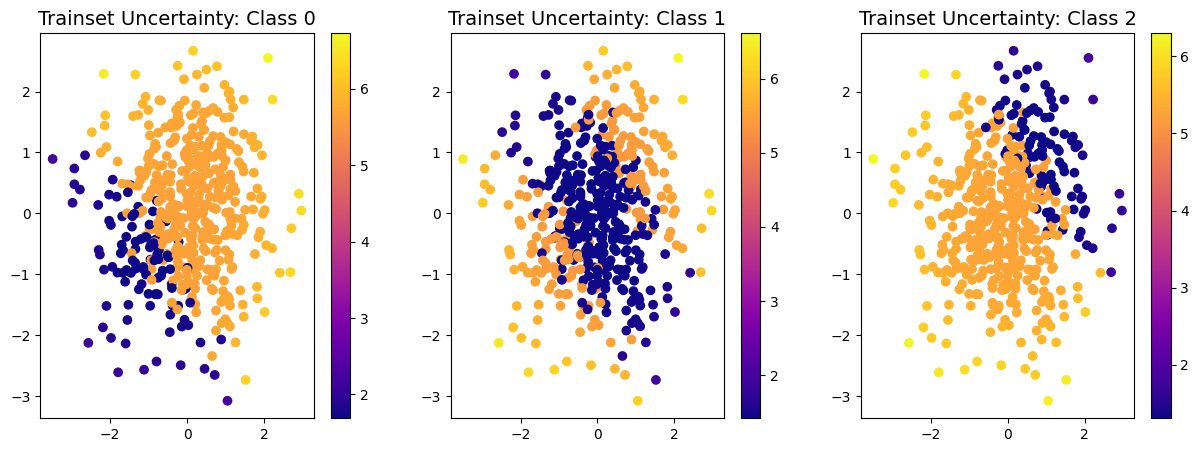

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].scatter(
        train_x[:,0].numpy(), train_x[:,1].numpy(), c=train_pred_variance[i], cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Trainset Uncertainty: Class " + str(i), fontsize = 14)



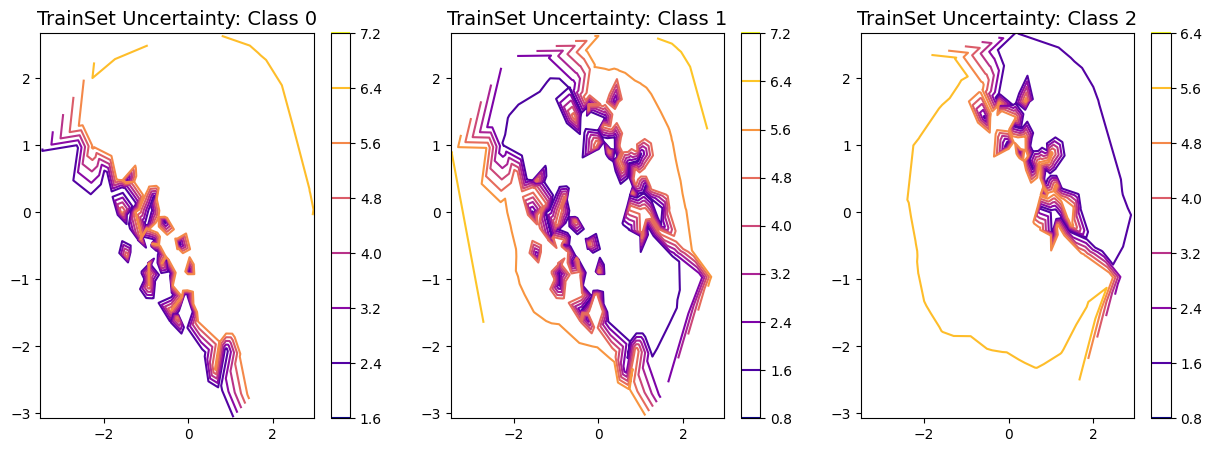

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].tricontour(
        train_x[:,0].numpy(), train_x[:,1].numpy(), train_pred_variance[i], cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("TrainSet Uncertainty: Class " + str(i), fontsize = 14)
